This is an explanation of the code line per line linking the decisions made to the langage used so the code can be easily modulated by someone else. To understand the model or the decisions made in this code, please refer to the PDF attached.

# Presentation of the code

Import package fipy: ('\*'means import all functions). 

Import random for the initial condition of the interface.

The math package is necessary for the activity term.

The numba package allows the operations to be resolved in C rather than Python.

In [4]:
from fipy import *
import random
from math import sqrt
from numba import jit

## Parameters

All the parameters are determined at the beginning of the code so there are easy to change and check.

The duration and sweeps are chosen out of the 1D simulation: We wait the stabilisation of the interface in the x direction before launching the dynamic part of the simulation.

In [5]:
U = 0.8 #mean speed
Mobility = 0.2 #ratio of the two viscosities; M_c in Hamouda's paper
epsilon = 0.4 #rules the with of teh interface / epsilon > 2*dx
l = 0.01 #this is lambda from Hamouda's paper: mixing energy density
duration = 1500. #stabilisation phase : nombre d'itérations afin d'avoir une phase stable au démarrage
sweeps = 41 #stabilisation vitesse
alpha1=0.25 

## Geometry and mesh

We install the geometry of the situation.
The simulation is 2D (W=1., L=1.).

### Mesh

The mesh is decided with the length of one controle volume.

In [6]:
dx = 0.15 #width of controle volume
dy = 0.5
nx = 300
ny = 100 #number of controle volume
mesh = Grid2D(dx=dx, dy=dy, nx=nx, ny=ny)

### Space

In [7]:
L = dx*nx #length
W = dy*ny #width: characteristic length
b = 1. #gap
print "L =",L, "; W =", W

L = 45.0 ; W = 50.0


## Description of the fluids

### Parameters

The cause of fingering is the ratio of the two viscosities. We can ste the second viscosity to one, to stay dimensionless.

Fluid 1 is the active fluid, less viscous.

Fluid 2 is the passive fluid, more viscous.  

The two permeabilities are set to 1.

We introduce the parameter beta, present in the model's formulas.

In [37]:
viscosity2 = 1.
M = Mobility * epsilon**2 #M in Hamouda's paper
viscosity1 = viscosity2 * Mobility
permeability1 = permeability2 = 1.
beta1 = viscosity1 / permeability1
beta2 = viscosity2 / permeability2

### Variable of the fluids

The grid is colocated in FiPy. We need to introduce a correction in the velocity to suppress oscillations. Therefore we need two variables of speed.
The xvelocity is already set up as U, so that the first time step will not cause values with a 0 denominator.

We have here two coupled equations: in order for the variables to respect both at each time step, we need an iterative scheme with a correction of the pressure at each iteration. For this correction, we use the a corrected continuity equation.
We introduce a new pressure variable that corresponds to the pressure once it has been corrected by the second equation, that will be used to begin again the iteration.

In [38]:
pressure = CellVariable(mesh=mesh, name='pressure')
pressureCorrection = CellVariable(mesh=mesh)
xVelocity = CellVariable(mesh=mesh, name='X Velocity', value=U)
yVelocity = CellVariable(mesh=mesh, name='Y Velocity')
velocity = FaceVariable(mesh=mesh, rank=1)

## Phase-field model

### Order parameter

The order parameter is phi. The hasOld option permits to pply an iterative scheme on the reolution of the phi equation without advancing in time step. Because the phase-field equation is not linear we need to iterate the solving of the equation at each time step. The commad hasOld permits to update the value of phi to use at the end of the iterations only.

In [39]:
phi = CellVariable(name=r'$\phi$', mesh=mesh, hasOld=1)

### Phase-field equation

The first line is the creation of an interpolation of the value of phi on to the faces. FiPy would have it done automatically, but it is more accurate to do it by arithmeticFaceValue (We also get to choose what type of interpolation we use) (why arithmetic?? I think because more precise is not needed, but I need to review, not the priority though)

The equation chosen for the phase-field is base on Cahn-Hilliard model as described in Hamouda's paper.

In [40]:
PHI = phi.arithmeticFaceValue #result more accurate by non-linear interpolation
coeff1 = Mobility * l * (6.* PHI*(PHI-1.) + 1.)
eq = (TransientTerm() + ConvectionTerm(velocity) == DiffusionTerm(coeff=coeff1) - DiffusionTerm(coeff=(M, l)))

## Boundary conditions

### Phase

This line is the outflow condition on the right.

In [41]:
phi.faceGrad.constrain([0.], mesh.facesRight | mesh.facesLeft)

'x,y = mesh.cellCenters' is to define x as the first axis so we can define the boundary conditions.

In [42]:
x = mesh.cellCenters[0]
y = mesh.cellCenters[1]

Phi is set up as a smooth function close to the solution so thatthe forst phase of stabilization of the interface will be quick. We set up a random initial condition in the position of the front of the phase so that we have a small random perturbation of the interface that permits the formation of fingers. The beginning of the simulation is at 0.2*L.

The first fluid is defined for phi=0. The second one is defined for phi=1.

In [43]:
def initialize(phi):
    for i in range(100):
        a = random.gauss(0.2, 0.005)
        phi.setValue(1-0.5*(1-numerix.tanh((x-nx*dx*a)/(2*numerix.sqrt(M*2*epsilon**2/l)))), where=(y<(i+1)*dy) & (y>(i*dy)))

initialize(phi)

### New values

The phase-field method means that the two fluids are not separated anymore: this means all the variable have to be defined on the whole domain. The particular variables are transformed by interpolation.

In [44]:
beta = CellVariable(mesh=mesh, name=r'$\beta$', value = beta2 * phi + beta1 * (1-phi))
alpha = CellVariable(mesh=mesh, name=r'$\alpha$', value = alpha1*(1.-phi))

## Pressure and velocity

### Equations

We then introduce the coupled equations.

First, equation of motion, here Darcy's law.

In [45]:
xVelocityEq = (ImplicitSourceTerm(coeff=beta) + pressure.grad[0] - ImplicitSourceTerm(alpha/(numerix.sqrt(xVelocity*xVelocity+yVelocity*yVelocity))))
yVelocityEq = (ImplicitSourceTerm(coeff=beta) + pressure.grad[1] - ImplicitSourceTerm(alpha/(numerix.sqrt(xVelocity*xVelocity+yVelocity*yVelocity))))

We then define the corrected equation of continuity, permitting the correction of the pressure.

In [46]:
coeff = 1./ beta.arithmeticFaceValue
pressureCorrectionEq = DiffusionTerm(coeff=coeff) - velocity.divergence

### Rhie-Chow correction

FiPy uses a colocated grid, causing oscillations in the velocity field. It is necessary to apply a correction called the Rhie-Chow correction. We define here the variables that will be necessary in the calculation of the velocity.

In [47]:
from fipy.variables.faceGradVariable import _FaceGradVariable

## Viewers

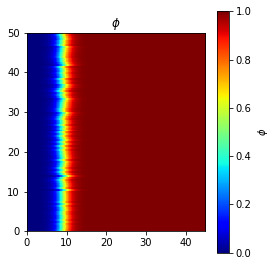

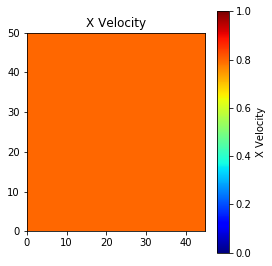

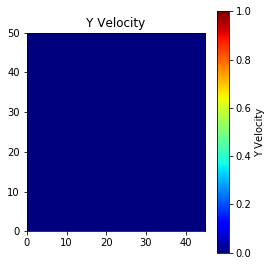

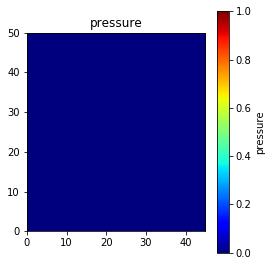

In [48]:
viewer = Viewer(vars = (phi), datamin=0., datamax=1.)
viewer2 = Viewer(vars = (xVelocity), datamin=0.7, datamax=0.9)
viewer3 = Viewer(vars = (yVelocity), datamin=0., datamax=1.)
viewer4 = Viewer(vars = (pressure), datamin=0., datamax=50.)

## Initialization

We need to initialize the phase to separate the effect of the formation of the phase-field interface from the kinematics of the problem.

### Phase field

The time step here is only used to resolve the equation. There are not time steps, but iterations to get a more accurate solution: by using the new value obtained at the solving of the equation, we are closer to the solution, so by solving it again with this value, we get a smaller residual, a more accurate solution. (we have a discretized solution, so the closer the values are when solving, the solution gets more accurate : by convergence.) 

The timestep is exponential because the Cahn-Hillair process slows with time.

The same process will be used in the global solution.

The solver used is the PCG Solver, the quickest: Preconditionate Conjugate Gradient method with symmetric successibe over-relaxation by default.

We apply the numba decorator "jit" to accelerate the solver.

In [17]:
dexp = 1.
elapsed = 0.

@jit
def updatephi(phi, elapsed, dexp):
    phi.updateOld()
    eq.solve(var=phi, dt = dt, solver= LinearPCGSolver())
    if __name__ == '__main__':
        viewer.plot()

while elapsed < duration:
    dt = min(100, numerix.exp(dexp))
    elapsed += dt
    dexp += 0.01
    updatephi(phi, elapsed, dexp)

KeyboardInterrupt: 

### Pressure and velocity fields

We define the boundary conditions for pressure and velocity only here so it does not perturbate the stabilisation of the phase (where the velocity needs to be 0 so that the convection term does not influence the formation of the phase-field interface).

In [49]:
xVelocity.constrain(U, mesh.facesLeft)
yVelocity.constrain(0, mesh.facesTop | mesh.facesBottom)
pressureCorrection.constrain(0., mesh.facesRight)

We use the SIMPLE algorithm that we will use at each iteration.
The relaxation are kept the same as in the example.

In [ ]:
pressureRelaxation = 0.8
velocityRelaxation = 0.5

@jit
def updatemotion(velocity, xVelocity, yVelocity, pressure, pressureCorrection, beta, phi,alpha):
    ##Solve the Stokes equations to get starred value
#    xVelocityEq.cacheMatrix()
    xres = xVelocityEq.sweep(var=xVelocity, underRelaxation=velocityRelaxation)
#    xmat = xVelocityEq.matrix
    yres = yVelocityEq.sweep(var=yVelocity, underRelaxation=velocityRelaxation)
    ##update the ap coefficient from the matrix diagonal
#    ap[:] = xmat.takeDiagonal()
    ##update the face velocities based on starred values with the Rhi-Chow correction
    #cell pressure gradient
    presgrad = pressure.grad
    #face pressure gradient
    facepresgrad = _FaceGradVariable(pressure)
    #
    velocity[0] = xVelocity.arithmeticFaceValue + 1. / beta.arithmeticFaceValue * (presgrad[0].arithmeticFaceValue-facepresgrad[0])
    velocity[1] = yVelocity.arithmeticFaceValue + 1. / beta.arithmeticFaceValue * (presgrad[1].arithmeticFaceValue-facepresgrad[1])
    velocity[0, mesh.facesLeft.value] = U
    velocity[0, mesh.facesRight.value] = U
    ##solve the pressure correction equation
    pressureCorrectionEq.cacheRHSvector()
    pres = pressureCorrectionEq.sweep(var=pressureCorrection)
    rhs = pressureCorrectionEq.RHSvector
    ## update the pressure using the corrected value
    pressure.setValue(pressure + pressureRelaxation * pressureCorrection)
    ## update the velocity using the corrected pressure
    xVelocity.setValue(xVelocity - pressureCorrection.grad[0] / beta)
    yVelocity.setValue(yVelocity - pressureCorrection.grad[1] / beta)
    xVelocity[0]=U
    xVelocity[nx-1]=U


for sweep in range(sweeps):
    updatemotion(velocity, xVelocity, yVelocity, pressure, pressureCorrection, beta, phi, alpha)

## Dynamics

In [ ]:
displacement = 60.
timeStep = 0.8 * dx / U #less than one space step per time step
elapsed = 0.

while elapsed < displacement/U:
    phi.updateOld()
    res = 1e+10
    while res > 1e-6:
        res = eq.sweep(var=phi, dt=timeStep, solver=LinearPCGSolver())
    beta.setValue(beta2 * phi + beta1 * (1.-phi))
    alpha.setValue(alpha1*(1.-phi))
    updatemotion(velocity, xVelocity, yVelocity, pressure, pressureCorrection, beta, phi)
    elapsed +=timeStep
    viewer.plot(filename="phi%d.png" % elapsed)
    viewer2.plot(filename="XVelocity%d.png" % elapsed)
    viewer4.plot(filename="pressure%d.png" % elapsed)
    viewer3.plot(filename="YVelocity%d.png" % elapsed)
    TSVViewer(vars=(phi, xVelocity, yVelocity, pressure,beta)).plot(filename="essaidonne%d.tsv" % elapsed)
    print(elapsed)

This line is to save the data created.

In [ ]:
TSVViewer(vars=(phi, xVelocity, yVelocity, pressure)).plot(filename="essaidonne.tsv")

This last line stops the code at the end so we are able to see the results.

In [ ]:
raw_input("pause")